In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import sklearn.metrics as sk
import os

In [3]:
def cargar_datos(nombre):
    lista_nombres = []
    lista_metodos_matrices=[]
    metodos = os.listdir('../folds/'+nombre)
    for metodo in metodos:
        matrices = pd.read_csv('../folds/'+nombre+'/'+metodo)
        matrices = procesar_input(matrices)
        lista_metodos_matrices.append(matrices)
        metodo = metodo[:-4]
        metodo = metodo.replace('_', ' ')
        aux = metodo.split('-')
        sup = aux[0].split(' ', 1)
        aux = sup + aux[1:]
        lista_nombres.append(aux)
    return(lista_nombres, lista_metodos_matrices)


In [4]:
def procesar_input(matrices_de_confusion):
    lista_matrices  = []
    for i in matrices_de_confusion.index:
        matriz_aux = (matrices_de_confusion.iloc[[i]]).values
        matriz_aux = matriz_aux.reshape(10,10)
        df_matriz = pd.DataFrame(data = matriz_aux)
        lista_matrices.append(df_matriz)
    return lista_matrices

def ver_simetria(matriz):
    matriz = matriz
    matriz_Trans = matriz.transpose()
    return (matriz - matriz_Trans).abs()

def accuracy(mat):
    dividendo = (pd.Series(np.diag(mat), index=[mat.index, mat.columns])).sum()
    aux =  dividendo / (mat.sum()).sum() 
    df = pd.DataFrame([aux], columns = ['accuracy'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

def accuracy_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, accuracy_aux = accuracy(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = accuracy_aux
    
    return (desvio, promedio, df)



def precision_clase(mat, clase):
    dividendo = mat.iat[clase, clase]
    divisor = mat[clase].sum()
    return dividendo/divisor

def precision(mat):
    prec = []
    for i in range(10):
        aux = precision_clase(mat,i)
        prec.append(aux)
    df = pd.DataFrame(prec, columns = ['precision'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

#precisionM es el parametro promedio que devolvemos
def precision_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, precision_aux = precision(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = precision_aux
    
    return (desvio, promedio, df)

def recall_clase(mat, clase):
    dividendo = mat.iat[clase, clase]
    divisor = mat.iloc[clase].sum()
    return dividendo/divisor
    
def recall(mat):
    rec = []
    for i in range(10):
        aux = recall_clase(mat, i)
        rec.append(aux)
    df = pd.DataFrame(rec, columns = ['recall'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

#RecallM es el parametro promedio que devolvemos
def recall_mat(lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, recall_aux = recall(lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = recall_aux
    
    return (desvio, promedio, df)

def F_score_clase(beta, mat, clase):
    prec = precision_clase(mat, clase)
    rec = recall_clase(mat, clase)
    dividendo = (beta**2 + 1) * prec*rec
    divisor = beta**2 * (prec + rec)
    return dividendo/divisor

def F_score(beta, mat):
    rec = []
    for i in range(10):
        aux = F_score_clase(beta, mat, i)
        rec.append(aux)
    df = pd.DataFrame(rec, columns = ['F'+str(beta)+'_score'])
    promedio = df.mean()
    desvio = df.std()
    return (desvio, promedio, df)

def F_score_mat(beta, lista_mat):
    desvio =pd.DataFrame()
    promedio = pd.DataFrame()
    df = pd.DataFrame()
     
    for i in range(len(lista_mat)):
        desvio_aux, promedio_aux, f_score_aux = F_score(beta, lista_mat[i])
        desvio['mat'+str(i)] = desvio_aux
        promedio['mat'+str(i)] = promedio_aux
        df['mat'+str(i)] = f_score_aux
    
    return (desvio, promedio, df)

def F_score_M(beta, lista_mat):
    desvio, precision_M, df = precision_mat(lista_mat)
    desvio, recall_M, df = recall_mat(lista_mat)
    precision_M.index = [0]
    recall_M.index = [0]
    dividendo = (beta**2 + 1)*precision_M * recall_M
    divisor = (beta**2 * precision_M) +recall_M
    return dividendo/divisor

In [5]:
#k_fold lineas donde la linea i es una matriz de confusion de la i_esima iteracion de k_fold
#nombres, lista_metodos = cargar_datos('KNN')
nombres_pca, lista_metodos_pca = cargar_datos('KNNPCA')
#nombres_mod, lista_metodos_mod = cargar_datos('KNNMOD')

In [6]:
#for nombre in nombres_pca:
#    print(nombre)


# Calculamos accuracy para cada metodo


In [7]:
def tags(lista_variables):
    etiqueta = ''
    if lista_variables[0] == 'KNN':
        etiqueta += str(lista_variables[1])
    if lista_variables[0] =='KNNPCA':
        etiqueta += str(lista_variables[1])+'\n'+str(lista_variables[2])
    if lista_variables[0] == 'KNNMODPCA':
        etiqueta += str(lista_variables[2])
    etiqueta += '\n'+ str(lista_variables[3])
    return etiqueta

In [175]:
def agregar_columnas(accuracy_total):
    knns = [100 for x in range(len(accuracy_total.index))]
    alphas = [-100 for x in range(len(accuracy_total.index))]
    kfolds = [0 for x in range(len(accuracy_total.index))]
    i = 0
    for ind in accuracy_total.index:
        lista = ind.split("\n")
        lista_piola = []
        for elem in lista:
            aux = elem.split()
            lista_piola.append(aux)
        for tripla in lista_piola:
            alpha = -100
            knn = 100
            kfold = 0
            if tripla[0] == 'k':
                knn = int(tripla[1])
                knns[i] = knn
            elif tripla[0] == 'alpha':
                alpha = int(tripla[1])
                alphas[i] = alpha
            elif tripla[0] == 'kfold':
                kfold = int(tripla[1])
                kfolds[i] = kfold

        i += 1
    accuracy_total['alpha'] = alphas
    accuracy_total['kfold'] = kfolds
    accuracy_total['knn'] = knns

    return accuracy_total

def accuracy_metodos(nombres, lista_metodos):
    i = 0
    accu = []
    etiquetas = []
    for metodo in lista_metodos:
        bla, bls, df = accuracy_mat(metodo)
    
        tag = tags(nombres[i])
        i += 1
        accu.append(df)
        etiquetas.append(tag)
        
    accuracy_total = pd.concat(accu)
    accuracy_total.index = etiquetas
    accuracy_total = agregar_columnas(accuracy_total)
    
    return accuracy_total

def F1_metodos(nombres, lista_metodos):
    i = 0
    f1 = []
    etiquetas = []
    for metodo in lista_metodos:
        df = F_score_M(1, metodo)
        
        tag = tags(nombres[i])
        i += 1
        f1.append(df)
        etiquetas.append(tag)
        
    accuracy_total = pd.concat(f1)
    accuracy_total.index = etiquetas
    accuracy_total = agregar_columnas(accuracy_total)

    return accuracy_total

def graficar(accuracy_total, metrica, metodo, save, orden):
    accuracy_total_knn = accuracy_total.sort_values(orden, axis = 0)
    
    orden_real = list(orden)
    orden.append('kfold')
    
    accuracy_total_knn.drop(orden, axis = 1, inplace = True)

    accuracy_total_knn = accuracy_total_knn.transpose().mean().to_frame()
    
    accuracy_total_knn = unir_folds(accuracy_total_knn)
    
    accuracy_total_knn = accuracy_total_knn.sort_values(orden_real, axis = 0)
    
    cant_grupos = len(accuracy_total_knn.index)//12
    principio = 0
    fin = 12
    
    for i in range(cant_grupos):
        valores = accuracy_total_knn.iloc[principio:fin, :]

        ac2 = valores['kfold 2'].values
        ac6 = valores['kfold 6'].values
        ac10 = valores['kfold 10'].values
        
        
        fig, ax = plt.subplots()
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        hd2, = ax.plot(ac2, 'bo', label = 'kfold 2.')
        hd6, = ax.plot(ac6, 'go', label = 'kfold 6.')
        hd10, = ax.plot(ac10, 'ro', label = 'kfold 10.')
        #escribo los valores del eje x.
        ax.set_xticks(range(len(valores.index.get_values())))
        ax.set_xticklabels(valores.index.get_values())
        ax.legend(handles=[hd2, hd6, hd10], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        
        
        ax.set_title(metrica+' con '+metodo+'.')

        if(save):
            ax.savefig(metrica+metodo+str(i)+'orden'+str(orden[0])+'.png')
        plt.show()
        principio = fin
        fin = principio + 12
    
    if principio < len(accuracy_total_knn.index) :
        valores = accuracy_total_knn.iloc[principio:, :]
     
        ac2 = valores['kfold 2'].values
        ac6 = valores['kfold 6'].values
        ac10 = valores['kfold 10'].values
        
        
        fig, ax = plt.subplots()
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        hd2, = ax.plot(ac2, 'bo', label = 'kfold 2.')
        hd6, = ax.plot(ac6, 'go', label = 'kfold 6.')
        hd10, = ax.plot(ac10, 'ro', label = 'kfold 10.')
        #escribo los valores del eje x.
        ax.set_xticks(range(len(valores.index.get_values())))
        ax.set_xticklabels(valores.index.get_values())
        ax.legend(handles=[hd2, hd6, hd10], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        
        ax.set_title(metrica+' con '+metodo+'.')

        if(save):
            ax.savefig(metrica+metodo+'orden'+str(orden[0])+'.png')
        plt.show()
        
def unir_folds(df):
    aux = [x.split('\n') for x in df.index.values]
    
    dataset = pd.DataFrame(columns = ['kfold 2', 'kfold 6', 'kfold 10','ind'])
    
    indice = []
    folds = []
    for elem in aux:
        folds.append(elem[2])
        alphas = elem[1].split()
        indice.append(elem[0]+'\n$\\'+alphas[0]+'$ '+alphas[1])

    df['kfold'] = folds
    df['mini_indice'] = indice
    grupos = df.groupby('mini_indice')
    for mini, df_aux in grupos:
        kf2 = df_aux.loc[df_aux['kfold'] == 'kfold 2'][0].get(0)
        kf6 = df_aux.loc[df_aux['kfold'] == 'kfold 6'][0].get(0)
        kf10 = df_aux.loc[df_aux['kfold'] == 'kfold 10'][0].get(0)
        dic = {'kfold 2': kf2, 'kfold 6': kf6, 'kfold 10': kf10,'ind': mini}
        dataset = dataset.append(dic, ignore_index = True)
    
    dataset.set_index(dataset['ind'].values, inplace = True)
    knnpca = [(x.split('\n')) for x in dataset['ind'].values]
    knn = [x[0] for x in knnpca]
    knn_aux = [x.split() for x in knn]
    knn = [int(x[1]) for x in knn_aux]
    pca = [x[1] for x in knnpca]
    pca_aux = [x.split() for x in pca]
    pca = [int(x[1]) for x in pca_aux]

    dataset['alpha'] = pca
    dataset['knn'] = knn
    dataset.drop('ind',axis = 1, inplace = True)
    return dataset
    

## Accuracy de Knn con distintos hiperparametros

#### Los graficos se ordenan de dos formas, agrupados por el knn y por el kfold

In [177]:
orden_knn = ['knn', 'alpha']
orden_alpha = ['alpha','knn']
ac = accuracy_metodos(nombres, lista_metodos)

print("knn")
graficar(ac, "Accuracy", "Knn", False, orden_knn)
print("kfold")
#graficar(ac, "Accuracy", "Knn", False, orden_kfold)

NameError: name 'nombres' is not defined

Podemos ver, dos cosas, la primera es que el knn que nos conviene es el k = 6, ya que en cada kfold esta por arriba de los otros. La segunda es que no importa que knn eligamos todos los metodos tienen una accuracy decreciente por el tamaño del kfold, esto es un comportamiento extremadamente extraño.

# Accuracy de Knn con PCA, para distintos parametros.

### como tenemos muchos metodos, van a haber muchisimos graficos, vamos separar los datos en distintos knn y despues vamos a graficar con dos ordenes, el alpha y el kfold.

[ 2  6 10 14]
kfold 6
knn: 2
alpha
                             mat0      mat1     mat2      mat3      mat4  \
k 2\nalpha 30\nkfold 6   0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 50\nkfold 6   0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 70\nkfold 6   0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 90\nkfold 6   0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 110\nkfold 6  0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 130\nkfold 6  0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 150\nkfold 6  0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 170\nkfold 6  0.933779  0.930208  0.93435  0.928351  0.929265   
k 2\nalpha 190\nkfold 6  0.933779  0.930208  0.93435  0.928351  0.929265   

                             mat5  mat6  mat7  mat8  mat9  alpha  kfold  knn  
k 2\nalpha 30\nkfold 6   0.928837   NaN   NaN   NaN   NaN     30      6    2  
k 2\nalpha 50\nkfold 6   0.928837   NaN   NaN 

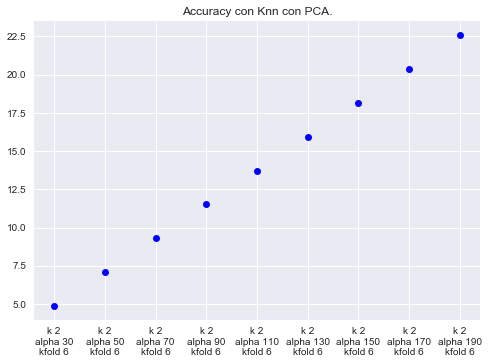

knn: 6
alpha
                             mat0      mat1     mat2      mat3      mat4  \
k 6\nalpha 30\nkfold 6   0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 50\nkfold 6   0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 70\nkfold 6   0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 90\nkfold 6   0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 110\nkfold 6  0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 130\nkfold 6  0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 150\nkfold 6  0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 170\nkfold 6  0.940207  0.937693  0.94015  0.937179  0.938264   
k 6\nalpha 190\nkfold 6  0.940207  0.937693  0.94015  0.937179  0.938264   

                            mat5  mat6  mat7  mat8  mat9  alpha  kfold  knn  
k 6\nalpha 30\nkfold 6   0.93855   NaN   NaN   NaN   NaN     30      6    6  
k 6\nalpha 50\nkfold 6   0.93855   NaN   NaN   NaN   NaN     50      6

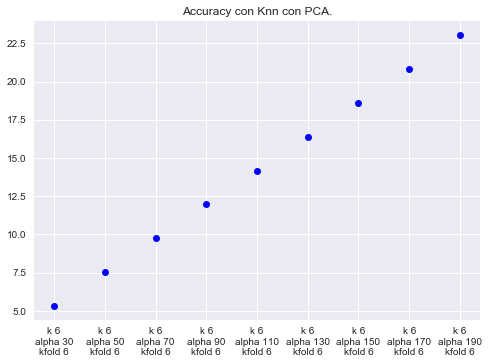

knn: 10
alpha
                              mat0      mat1      mat2      mat3      mat4  \
k 10\nalpha 30\nkfold 6   0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 50\nkfold 6   0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 70\nkfold 6   0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 90\nkfold 6   0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 110\nkfold 6  0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 130\nkfold 6  0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 150\nkfold 6  0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 170\nkfold 6  0.934665  0.933179  0.935579  0.932265  0.934522   
k 10\nalpha 190\nkfold 6  0.934665  0.933179  0.935579  0.932265  0.934522   

                              mat5  mat6  mat7  mat8  mat9  alpha  kfold  knn  
k 10\nalpha 30\nkfold 6   0.934065   NaN   NaN   NaN   NaN     30      6   10  
k 10\nalpha 50\nkfold 6   0.934065   NaN   Na

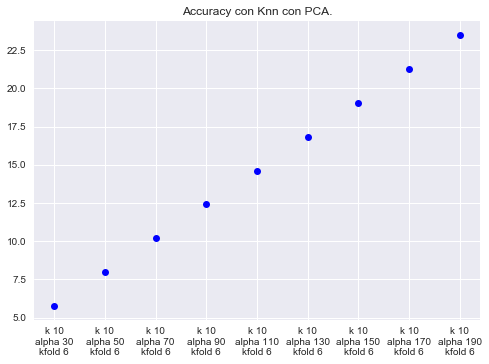

knn: 14
alpha
                              mat0      mat1      mat2      mat3      mat4  \
k 14\nalpha 30\nkfold 6   0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 50\nkfold 6   0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 70\nkfold 6   0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 90\nkfold 6   0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 110\nkfold 6  0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 130\nkfold 6  0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 150\nkfold 6  0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 170\nkfold 6  0.931208  0.929494  0.929779  0.927465  0.930808   
k 14\nalpha 190\nkfold 6  0.931208  0.929494  0.929779  0.927465  0.930808   

                              mat5  mat6  mat7  mat8  mat9  alpha  kfold  knn  
k 14\nalpha 30\nkfold 6   0.930151   NaN   NaN   NaN   NaN     30      6   14  
k 14\nalpha 50\nkfold 6   0.930151   NaN   Na

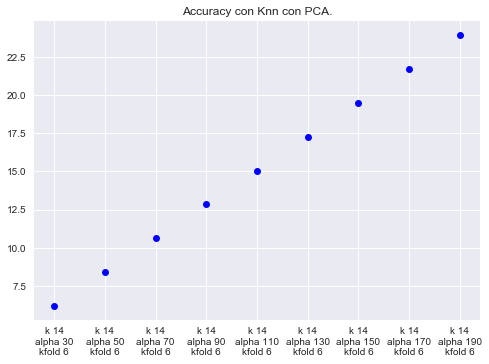

kfold 2
knn: 2
alpha
                             mat0      mat1  mat2  mat3  mat4  mat5  mat6  \
k 2\nalpha 30\nkfold 2   0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 50\nkfold 2   0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 70\nkfold 2   0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 90\nkfold 2   0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 110\nkfold 2  0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 130\nkfold 2  0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 150\nkfold 2  0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 170\nkfold 2  0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   
k 2\nalpha 190\nkfold 2  0.952245  0.951674   NaN   NaN   NaN   NaN   NaN   

                         mat7  mat8  mat9  alpha  kfold  knn  
k 2\nalpha 30\nkfold 2    NaN   NaN   NaN     30      2    2  
k 2\nalpha 50\nkfold 2    NaN   NaN   NaN     50      2    2  
k 2\nalpha 70\nkfol

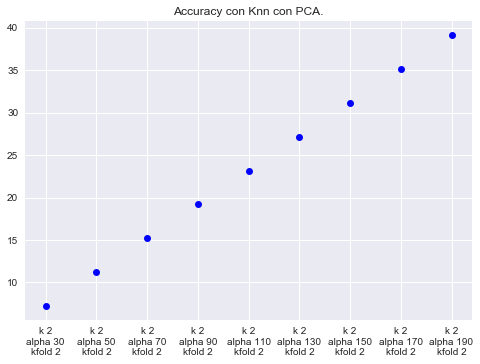

knn: 6
alpha
                             mat0     mat1  mat2  mat3  mat4  mat5  mat6  \
k 6\nalpha 30\nkfold 2   0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 50\nkfold 2   0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 70\nkfold 2   0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 90\nkfold 2   0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 110\nkfold 2  0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 130\nkfold 2  0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 150\nkfold 2  0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 170\nkfold 2  0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   
k 6\nalpha 190\nkfold 2  0.959625  0.95953   NaN   NaN   NaN   NaN   NaN   

                         mat7  mat8  mat9  alpha  kfold  knn  
k 6\nalpha 30\nkfold 2    NaN   NaN   NaN     30      2    6  
k 6\nalpha 50\nkfold 2    NaN   NaN   NaN     50      2    6  
k 6\nalpha 70\nkfold 2    NaN   NaN  

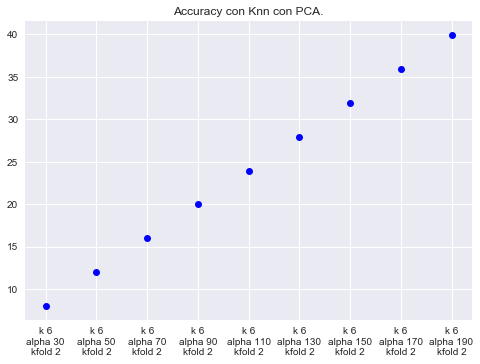

knn: 10
alpha
                              mat0      mat1  mat2  mat3  mat4  mat5  mat6  \
k 10\nalpha 30\nkfold 2   0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 50\nkfold 2   0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 70\nkfold 2   0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 90\nkfold 2   0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 110\nkfold 2  0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 130\nkfold 2  0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 150\nkfold 2  0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 170\nkfold 2  0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   
k 10\nalpha 190\nkfold 2  0.955959  0.957149   NaN   NaN   NaN   NaN   NaN   

                          mat7  mat8  mat9  alpha  kfold  knn  
k 10\nalpha 30\nkfold 2    NaN   NaN   NaN     30      2   10  
k 10\nalpha 50\nkfold 2    NaN   NaN   NaN     50      2   10  
k 10\nalpha 7

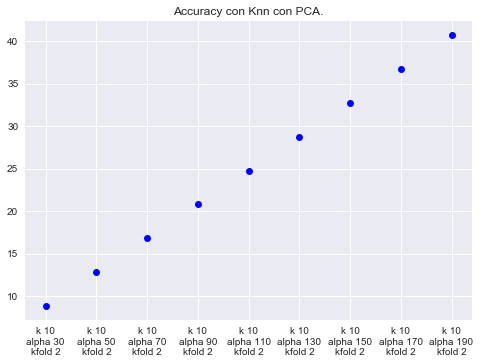

knn: 14
alpha
                              mat0     mat1  mat2  mat3  mat4  mat5  mat6  \
k 14\nalpha 30\nkfold 2   0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 50\nkfold 2   0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 70\nkfold 2   0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 90\nkfold 2   0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 110\nkfold 2  0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 130\nkfold 2  0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 150\nkfold 2  0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 170\nkfold 2  0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   
k 14\nalpha 190\nkfold 2  0.952959  0.95334   NaN   NaN   NaN   NaN   NaN   

                          mat7  mat8  mat9  alpha  kfold  knn  
k 14\nalpha 30\nkfold 2    NaN   NaN   NaN     30      2   14  
k 14\nalpha 50\nkfold 2    NaN   NaN   NaN     50      2   14  
k 14\nalpha 70\nkfold 2

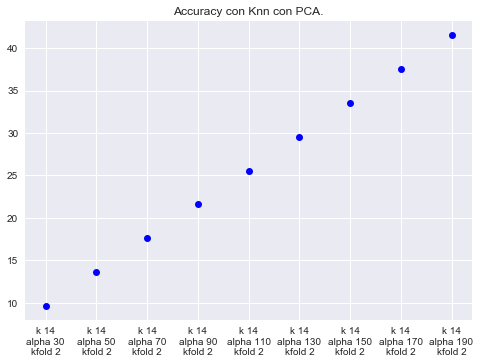

kfold 10
knn: 2
alpha
                              mat0      mat1      mat2      mat3      mat4  \
k 2\nalpha 30\nkfold 10   0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 50\nkfold 10   0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 70\nkfold 10   0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 90\nkfold 10   0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 110\nkfold 10  0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 130\nkfold 10  0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 150\nkfold 10  0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 170\nkfold 10  0.913792  0.919479  0.919453  0.914215  0.914903   
k 2\nalpha 190\nkfold 10  0.913792  0.919479  0.919453  0.914215  0.914903   

                              mat5      mat6      mat7     mat8      mat9  \
k 2\nalpha 30\nkfold 10   0.918765  0.912258  0.916146  0.91731  0.916596   
k 2\nalpha 50\nkfold 10   0.918765  0.91225

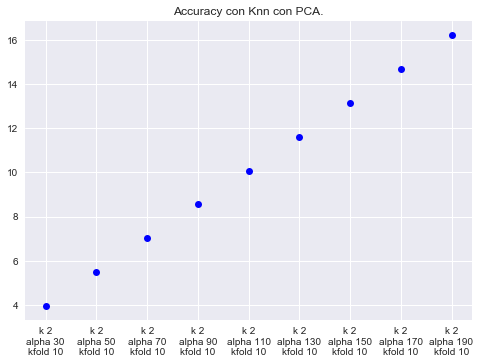

knn: 6
alpha
                              mat0      mat1      mat2      mat3    mat4  \
k 6\nalpha 30\nkfold 10   0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 50\nkfold 10   0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 70\nkfold 10   0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 90\nkfold 10   0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 110\nkfold 10  0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 130\nkfold 10  0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 150\nkfold 10  0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 170\nkfold 10  0.924902  0.927997  0.926833  0.924082  0.9276   
k 6\nalpha 190\nkfold 10  0.924902  0.927997  0.926833  0.924082  0.9276   

                              mat5      mat6      mat7      mat8      mat9  \
k 6\nalpha 30\nkfold 10   0.928129  0.922812  0.925881  0.925405  0.925352   
k 6\nalpha 50\nkfold 10   0.928129  0.922812  0.925881  0.925405  0.92

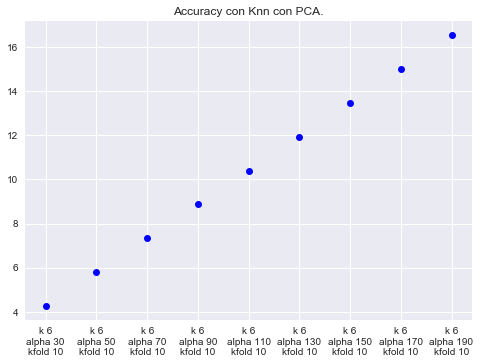

knn: 10
alpha
                               mat0      mat1      mat2      mat3      mat4  \
k 10\nalpha 30\nkfold 10   0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 50\nkfold 10   0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 70\nkfold 10   0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 90\nkfold 10   0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 110\nkfold 10  0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 130\nkfold 10  0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 150\nkfold 10  0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 170\nkfold 10  0.919427  0.922574  0.919453  0.918342  0.923474   
k 10\nalpha 190\nkfold 10  0.919427  0.922574  0.919453  0.918342  0.923474   

                             mat5      mat6      mat7      mat8      mat9  \
k 10\nalpha 30\nkfold 10   0.9244  0.917866  0.920855  0.919453  0.919717   
k 10\nalpha 50\nkfold 10   0.9244  0.9178

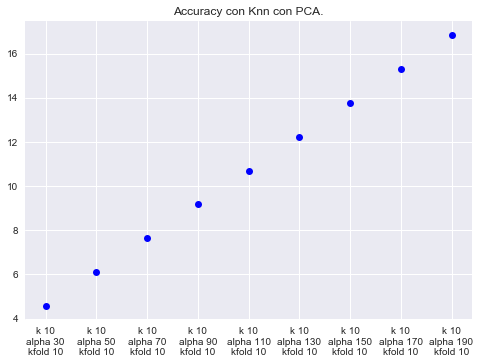

knn: 14
alpha
                               mat0      mat1      mat2      mat3      mat4  \
k 14\nalpha 30\nkfold 10   0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 50\nkfold 10   0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 70\nkfold 10   0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 90\nkfold 10   0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 110\nkfold 10  0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 130\nkfold 10  0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 150\nkfold 10  0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 170\nkfold 10  0.914427  0.917178  0.913686  0.913263  0.917998   
k 14\nalpha 190\nkfold 10  0.914427  0.917178  0.913686  0.913263  0.917998   

                               mat5      mat6      mat7      mat8      mat9  \
k 14\nalpha 30\nkfold 10   0.917945  0.911544  0.916517  0.913819  0.914295   
k 14\nalpha 50\nkfold 10   0.917945  

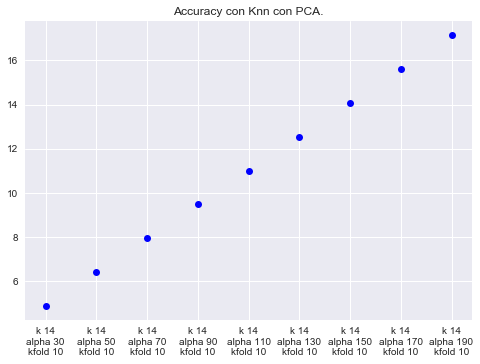

knn: 2
alpha
Empty DataFrame
Columns: [mat0, mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, alpha, kfold, knn]
Index: []
knn: 6
alpha
Empty DataFrame
Columns: [mat0, mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, alpha, kfold, knn]
Index: []
knn: 10
alpha
Empty DataFrame
Columns: [mat0, mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, alpha, kfold, knn]
Index: []
knn: 14
alpha
Empty DataFrame
Columns: [mat0, mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, alpha, kfold, knn]
Index: []
alpha
Empty DataFrame
Columns: [mat0, mat1, mat2, mat3, mat4, mat5, mat6, mat7, mat8, mat9, alpha, kfold, knn]
Index: []


In [10]:

ac_pca = accuracy_metodos(nombres_pca, lista_metodos_pca)
knns = ac_pca.knn.unique()
print(knns)
print("kfold 6")
for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.kfold == 6]
    print("alpha")
    graficar(ac_aux, "Accuracy", "Knn con PCA", False, orden_alpha)
    #print("kfold")
    #graficar_orden_kfold(ac_aux, "Accuracy", "Knn con PCA")

print("kfold 2")
for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.kfold == 2]
    print("alpha")
    graficar(ac_aux, "Accuracy", "Knn con PCA", False, orden_alpha)

print("kfold 10")
for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.kfold == 10]
    print("alpha")
    graficar(ac_aux, "Accuracy", "Knn con PCA", False, orden_alpha)

for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.alpha == 60]
    print("alpha")
    graficar(ac_aux, "Accuracy", "Knn con PCA", False, orden_kfold)

ac_aux = ac_pca[ac_pca.alpha == 60] 
print("alpha")
graficar(ac_aux, "Accuracy", "Knn con PCA", False, orden_kfold)


# calculamos F1 score

(esto es para mostrar lo que podemos hacer, es decir hice F1, pero podriamos haber hecho otra cosa)

## En este segmento vamos a calcular la F1 score M
### esto nos da un F1 score unificada para las 10 clases. es decir tenemos un valor por cada matriz que genera el kfold. Al tener un valor unificado, podemos ver como se comporta nuestros distintos algoritmos con un violin plot, de manera mas resumida. perdemos información, pero es mas fácil de disernir

In [ ]:
ac = F1_metodos(nombres, lista_metodos)
print("knn")
graficar_orden_knn(ac, "F1 score", "Knn", False)
print("kfold")
graficar_orden_kfold(ac, "F1 score", "Knn", False)

In [ ]:
ac_pca = F1_metodos(nombres_pca, lista_metodos_pca)
knns = ac_pca.knn.unique()


for k in knns:
    print("knn: " +str(k))    
    ac_aux = ac_pca[ac_pca.knn == k] 
    ac_aux = ac_aux[ac_aux.alpha > 60]
    ac_aux = ac_aux[ac_aux.alpha < 310]
    #ac_aux = ac_aux[ac_aux.kfold == 6]
    #graficar_orden_alpha(ac_aux,  "F 1 score", "Knn con PCA", False)
    print("kfold")
    graficar_orden_kfold(ac_aux,  "F 1 score", "Knn con PCA", False)

# Vemos KNN MOD

In [ ]:
ac = accuracy_metodos(nombres_mod, lista_metodos_mod)
ac
print("knn")
graficar_orden_knn(ac, "Accuracy", "Knn Modificado ", False)
print("kfold")
#graficar_orden_kfold(ac, "Accuracy", "Knn", False)
desvio, promedio, df = F_score_mat(1, lista_metodos_mod[1])
sns.violinplot(df.transpose())
plt.xlabel("clases")
plt.title(titulos(nombres_mod[1]))
plt.show()

### Malo

# nos quedamos con los preseleccionados.

### KNN = [6]
### KNNPCA = [(2, 60),(6, 60), (10, 60)]
### KNNMOD = []

In [ ]:
#nombres_pca, lista_metodos_pca
#nombres, lista_metodos
nombres_preselec = []
lista_metodos_preselec = []
for i in range(len(nombres)):
    if(nombres[i][1] == 'k 6'):
        nombres_preselec.append(nombres[i])
        lista_metodos_preselec.append(lista_metodos[i])
        
        
for i in range(len(nombres_pca)):
    if(nombres_pca[i][2] == 'alpha 60'):
        nombres_preselec.append(nombres_pca[i])
        lista_metodos_preselec.append(lista_metodos_pca[i])
##falta lo de nico

In [ ]:
ac = accuracy_metodos(nombres_preselec, lista_metodos_preselec)
ac = ac[ac.kfold == 6]
print("knn")
graficar_orden_alpha(ac, "Accuracy", "Knn/Knn con PCA", False)

In [ ]:
ac = F1_metodos(nombres_preselec, lista_metodos_preselec)
#ac = ac[ac.kfold == 6]
ac_2 = ac[ac.kfold == 2]
ac_6 = ac[ac.kfold == 6]
ac_10 = ac[ac.kfold == 10]

graficar_orden_alpha(ac_2, "F1 score", "Knn/Knn PCA", False)
graficar_orden_alpha(ac_6, "F1 score", "Knn/Knn PCA", False)
graficar_orden_alpha(ac_10, "F1 score", "Knn/Knn PCA", False)

## ahora calcula mos el F1 score para cada clase

### esto nos deja ver el comportamiento de cada clase por separado, todavia no se que es mejor, tener graficos por clase y en ellos cada variante de nuestro algoritmo O tener graficos por algoritmos para ver como se comportan las calses en un algoritmo dado. Aunque estos graficos tengan escencialemente la misma información, se ven dos cosas distintas... asi que no se, por ahora voy a dejar las dos opciones

## grafico por algoritmo

In [ ]:
def titulos(lista_variables):
    etiqueta = ''
    if lista_variables[0] == 'KNN':
        etiqueta +='Knn ' + str(lista_variables[1])
    if lista_variables[0] =='KNNPCA':
        etiqueta += 'Knn con PCA '+str(lista_variables[1])+' '+str(lista_variables[2])
    if lista_variables[0] == 'KNNMODPCA':
        etiqueta +='Knn modificado '+ str(lista_variables[2])
    etiqueta += ' '+ str(lista_variables[3])
    return etiqueta

In [ ]:
fold = ['kfold 2','kfold 6','kfold 10']
for k in fold:
    print(k)
    for i in range(len(nombres_preselec)):
        if(nombres_preselec[i][3] == k):
            desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
            sns.violinplot(df.transpose())
            plt.xlabel("clases")
            plt.title(titulos(nombres_preselec[i]))
            plt.show()

## por clase

In [ ]:
clases_2 = [[] for x in range(10)]
etiquetas_2 = []
clases_6 = [[] for x in range(10)]
etiquetas_6 = []
clases_10 = [[] for x in range(10)]
etiquetas_10 = []
for i in range(len(nombres_preselec)):
    if(nombres_preselec[i][3] == 'kfold 6'):
        desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
        etiqueta = tags(nombres_preselec[i])
        etiquetas_6.append(etiqueta)
        for j in df.index:
            aux = df.iloc[j].to_frame()
            clases_6[j].append(aux)
    if(nombres_preselec[i][3] == 'kfold 2'):
        desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
        etiqueta = tags(nombres_preselec[i])
        etiquetas_2.append(etiqueta)
        for j in df.index:
            aux = df.iloc[j].to_frame()
            clases_2[j].append(aux)
    if(nombres_preselec[i][3] == 'kfold 10'):
        desvio, promedio, df = F_score_mat(1, lista_metodos_preselec[i])
        etiqueta = tags(nombres_preselec[i])
        etiquetas_10.append(etiqueta)
        for j in df.index:
            aux = df.iloc[j].to_frame()
            clases_10[j].append(aux)
            

In [ ]:
for i in range(10):
    data = pd.concat(clases_2[i], axis = 1)
    data.columns = etiquetas_2
    sns.violinplot(data)
    plt.title('clase '+str(i)+' fold 2.')
    plt.show()

In [ ]:
for i in range(10):
    data = pd.concat(clases_6[i], axis = 1)
    data.columns = etiquetas_6
    sns.violinplot(data)
    plt.title('clase '+str(i)+' fold 6.')
    plt.show()

In [ ]:
for i in range(10):
    data = pd.concat(clases_10[i], axis = 1)
    data.columns = etiquetas_10
    sns.violinplot(data)
    plt.title('clase '+str(i)+' fold 10.')
    plt.show()

### Como podemos observar, ningun metodo es superior a todos los demas para todas las clases. Esto nos da un nuevo metodo, como un meta KNN donde agarramos varios knn y cada uno va a dar un resultado, dependiendo de que tan bien se comportaba en la clase que predijo tiene un voto pesado y hay una democracia ponderada

In [ ]:
def valor_ponderado_clase(metodo_clases, i):
    promedios = []
    for elem in metodo_clases:
        aux = (elem.mean()).get(i)
        promedios.append(aux)
    minimo = min(promedios)
    maximo = max(promedios)
    dif = int((maximo - minimo)*1000)
    
    return dif

def puntaje_clase(metodo_clase, i):
    ponderado = valor_ponderado_clase(metodo_clase, i)
    promedios = []
    for elem in metodo_clase:
        aux = (elem.mean()).get(i)
        
        promedios.append(aux)
    promedios = np.array(promedios)
    index = np.argsort(promedios)
    puntajes = [0 for x in range(len(metodo_clase))]
    punto = 1
    for i in index:
        puntajes[i] = punto * ponderado
        punto += 1
    return puntajes

## Para elegir el algoritmo decidimos, hacer unas cuentas locas, explicadas en el informe... aca estan.

In [ ]:
datos = []
for i in range(len(clases_2)):
    puntaje = puntaje_clase(clases_2[i], i)
    datos.append(puntaje)

In [ ]:
df = pd.DataFrame(datos)
#los puntajes por clases
print(df)
#el podio
print(df.sum())
print(etiquetas_2[1])

In [ ]:
datos = []
for i in range(len(clases_6)):
    puntaje = puntaje_clase(clases_6[i], i)
    datos.append(puntaje)
    

In [ ]:
df = pd.DataFrame(datos)
#los puntajes por clases
print(df)
#el podio
print(df.sum())
print(etiquetas_6[3])

In [ ]:
datos = []
for i in range(len(clases_10)):
    puntaje = puntaje_clase(clases_10[i], i)
    datos.append(puntaje)

In [ ]:
    
df = pd.DataFrame(datos)
#los puntajes por clases
print(df)
#el podio
print(df.sum())
print(etiquetas_10[1])

# Simetría

In [ ]:
nombres_preselec[-2]
final = lista_metodos_preselec[-2]
des, prom, acu = accuracy_mat(final)

In [ ]:
peor = final[3]
mejor = final[1]
peor_aux = peor.copy(deep = False)
np.fill_diagonal(peor_aux.values, 0)
sim_peor = ver_simetria(peor)

sns.heatmap(data = sim_peor, annot = peor_aux, cmap = "Blues", fmt = 'g',cbar_kws={'label': 'grado de semejanza'})
plt.xlabel("predición")
plt.ylabel("clase real")
plt.yticks(rotation=0)
plt.title("alpha: 60 k: 6 peor accuracy.")
plt.savefig('peor_heatmap.png')
plt.show()

In [ ]:
peor

In [ ]:
mejor_aux = mejor.copy(deep = False)
np.fill_diagonal(mejor_aux.values, 0)
sim_mejor = ver_simetria(mejor)

sns.heatmap(data = sim_mejor, annot = mejor_aux, cmap = "Blues", fmt = 'g',cbar_kws={'label': 'grado de semejanza'})
plt.xlabel("predición")
plt.ylabel("clase real")
plt.yticks(rotation=0)
plt.title("alpha: 60 k: 6 mejor accuracy.")
plt.savefig('mejor_heatmap.png')
plt.show()

In [ ]:
mejor

La idea de este heatmap es ver si cuando si se confunde de la misma forma, ejempo, tengo una foto de un 5 y me dice que es un 6, quiero ver si cuando mira una foto de un 6 se confunde masomenos la misma cantidad de veces.
Para hacer eso, agarra la matriz y le reste su traspuesta, es decir A(i,j) - A(j, i) cuanto mas cercano a cero es mas similares son las prediciones de ambos lados, si es muy positivo, es por que predice mas veces A(i,j) y cuando es negativo predice mas veces A(j, i).
Lo que nos faltaria ver, para que este grafico este piola, serian los valores reales de cada posicion. Creo que se entiende por que... Si en la posicion A(9,7) esta asi por que en realidad habia un 6 ahi y un 0 en la pos (7,9) entonces es un indicador de que no se confunde de la misma forma el 7 con el nueve que el 9 con el 7... pero si habia 600, eso implica que en la posicion A(7,9) habia 594 y eso diria que se confunden relativamente igual. Hay se ve un poco mejor(dejo esto para que entiendan los numeros y esas cosas)
Saque la diagonal por que... es obvio que da 0 y ensucia un grafico que ya esta bastante cargado.

In [ ]:
#plt.plot(tiempos, )x